In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import glob
import pickle
import pandas as pd
import pyccl as ccl
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import pyccl as ccl
import clmm
from scipy import stats
from clmm import Cosmology

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_completeness as comp
import model_purity as pur
import model_halo_mass_function as hmf
import class_richness_mass_relation as rm_relation
import model_cluster_abundance as cl_count
import model_stacked_cluster_mass as cl_mass
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme

In [2]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'

In [3]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
which_model = 'log_normal_poisson_log_scatter'#sim_mr_rel.which_model
sigma_wl_log10mass = 0.25/np.log(10)#sim_mr_rel.sigma_wl_log10mass
RM = rm_relation.Richness_mass_relation()
RM.select(which = which_model)

In [4]:
logm_edges = binning_scheme.logm_edges
redshift_edges = binning_scheme.redshift_edges
richness_edges = binning_scheme.richness_edges
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

In [5]:
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [6]:
data = load(f'/pbs/throng/lsst/users/cpayerne/capish/pinocchio_data_vector/data_vector_pinocchio_mock_{which_model}_sigma_lnMwl={sigma_wl_log10mass*np.log(10):.2f}.pkl')

# Comparison to prediction (count and mean mass)

In [7]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)

In [8]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(14.2, 16, 200)
z_grid = np.linspace(.2, 1, 201)

In [9]:
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_richness_mass_relation': theta_rm, 'model_richness_mass_relation': which_model,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation':None}
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':False,
          'compute_dNdzdlogMdOmega_log_slope': False}

In [10]:
count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

In [11]:
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [12]:
Omega = 0.25*(4*np.pi)
Nth = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

In [13]:
Nlog10Mth = Omega * cl_mass.Cluster_dNd0mega_Mass_ProxyZ(bins, integrand_count = integrand_count, grids = grids, Nlog10m = True)
log10Mth = Nlog10Mth/Nth

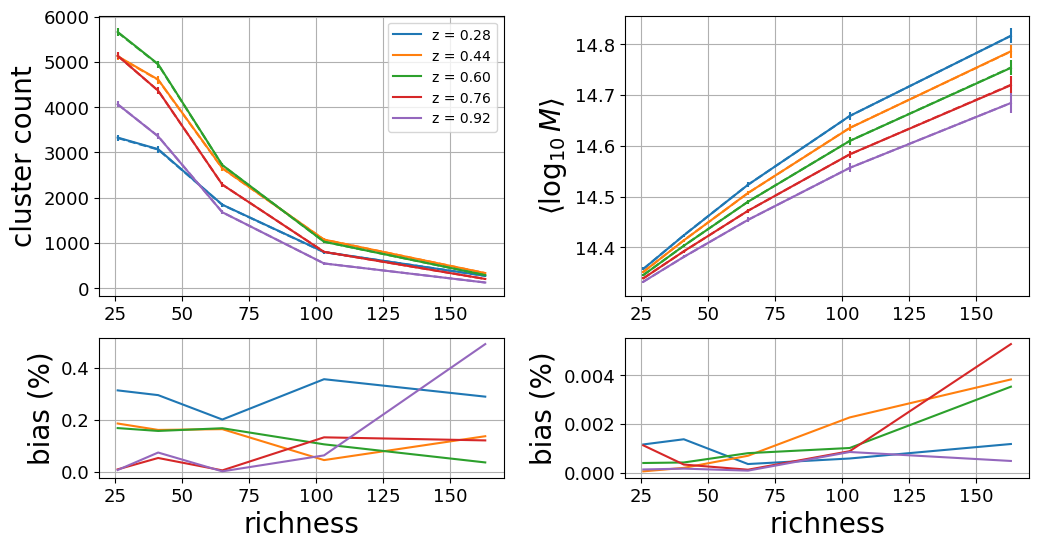

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [2,1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=None)
for i in range(5):
    ax[0,0].errorbar(np.mean(Richness_bin, axis=1), Nth[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
    ax[0,0].errorbar(np.mean(Richness_bin, axis=1),  data['mean_count_richness_redshift'][:,i], data['err_mean_count_richness_redshift'][:,i], fmt= '--', color = f'C{i}')
    ax[1,0].plot(np.mean(Richness_bin, axis=1), 100*abs(Nth[:,i] - data['mean_count_richness_redshift'][:,i])/Nth[:,i],  color = f'C{i}')

for i in range(5):
    ax[0,1].errorbar(np.mean(Richness_bin, axis=1), log10Mth[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
    ax[0,1].errorbar(np.mean(Richness_bin, axis=1),  data['mean_log10mass_richness_redshift'][:,i], data['err_mean_log10mass_richness_redshift'][:,i], fmt='--', color = f'C{i}')
    ax[1,1].errorbar(np.mean(Richness_bin, axis=1), 100*abs(log10Mth[:,i] - data['mean_log10mass_richness_redshift'][:,i])/log10Mth[:,i], label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')

    for i in range(2):
        ax[1,i].set_ylabel('bias (%)', fontsize=20,)
        ax[0,0].set_ylabel('cluster count', fontsize=20,)
        ax[0,1].set_ylabel(r'$\langle \log_{10} M\rangle$', fontsize=20,)
        ax[1,i].set_xlabel('richness', fontsize=20,)
        for j in range(2):
            ax[i,j].grid(which='both')
            ax[0,0].legend()
            ax[i,j].tick_params(axis='both', which = 'major', labelsize= 13)

plt.tick_params(axis='both', which = 'major', labelsize= 13)